In [61]:
import torch

device = torch.device("cuda")

In [62]:
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512, bias=False),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 7),
).to(device)
model.load_state_dict(torch.load("model_states/epoch3.pt"))
#model.fc.load_state_dict(torch.load("layers.pt"))

# weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
# model = mobilenet_v3_large(weights=weights).to(device)
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(960, 960, bias=False),
#     torch.nn.BatchNorm1d(960),
#     torch.nn.Dropout(p=0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(960, 960, bias=False),
#     torch.nn.BatchNorm1d(960),
#     torch.nn.Dropout(p=0.2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(960, 7),
# ).to(device)
# model.load_state_dict(torch.load("mobile_states/epoch20.pt"))
#model.classifier.load_state_dict(torch.load("layers.pt"))

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:
import os
import json
from torchvision.io import read_image
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T

class CountingDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file) as f:
            self.labels_dict = json.load(f)
        self.img_dir = img_dir
        self.images_list = [x for x in os.listdir(img_dir) if "testset3" in x]

        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = self.images_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path) / 255.0

        label = int(self.labels_dict[img_name])
        if self.transform:
            image = self.transform(image)

        return image, label
    
annotations_file = "../Apple/test_data/counting/ground_truth.json"
img_dir = "../Apple/test_data/counting/images/"
transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = CountingDataset(annotations_file, img_dir, transform=transform)

batch_size = 128
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [64]:
import numpy as np

truths = []
preds = []

confusion_matrix = np.zeros((7,7))

In [65]:
with torch.no_grad():
    for test_images, test_labels in (test_dataloader):
        pred = model(test_images.to(device)).argmax(dim=1).cpu()
        truths += test_labels.tolist()
        preds += pred.tolist()

        for label,p in zip(test_labels.tolist(), pred.tolist()):
            confusion_matrix[label, p] += 1

In [66]:
for row in confusion_matrix:
    s = np.sum(row)
    if s == 0:
        continue
    row /= np.sum(row)

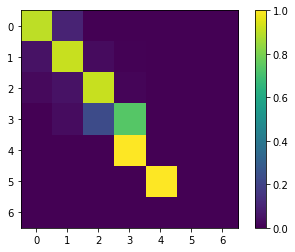

In [67]:
from matplotlib import pyplot as plt

plt.imshow(confusion_matrix)
plt.colorbar()

In [68]:
arr_truths = np.array(truths)
arr_preds = np.array(preds)

In [69]:
np.count_nonzero(arr_truths-arr_preds) / len(truths)

0.10714285714285714